# Predicting chaos

In [127]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

Generate a 3-d time series for the Lorenz equations with parameters selected to produce "butterfly" strange attractors.

In [121]:
import scipy.integrate

def dfunc(state, t0, sigma=10.0, beta=8/3.0, rho=58.0):
    x, y, z = state
    return np.array([ sigma*(y-x), x*(rho-z)-y, x*y-beta*z])
    
tvals = np.linspace(0.0, 20.0, 9999)    
xyz = scipy.integrate.odeint( dfunc, [1.0, 1.0, 1.0], tvals )
xyz.shape

(9999, 3)

Text(0.5,0,'integration timestep')

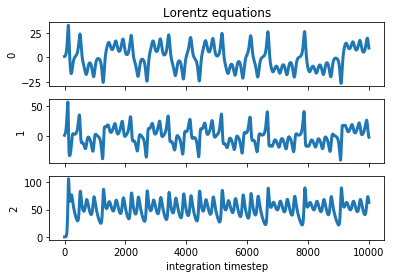

In [122]:
fig, axes = plt.subplots(3, sharex=True)
for indx in [0,1,2]:
    axes[indx].plot( result[:,indx], lw=3 )
    axes[indx].set_ylabel(str(indx))
axes[0].set_title('Lorentz equations') 
axes[-1].set_xlabel('integration timestep')

### Deep thoughtless

Build a simple model to use current state at time `T` to predict future state at time `T + dt`

In [124]:
from keras.models import Model, Sequential
from keras.layers import Input, Dense

In [125]:
# create model
model = Sequential()
model.add(Dense(8, input_dim=3, activation='relu'))
model.add(Dense(11, activation='relu'))
model.add(Dense(6, activation='relu'))
model.add(Dense(3, activation='linear')) #sigmoid'))

# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')

In [126]:
stack = []
ndt = 99  # future prediction time shift

#use points [0:900] to predict points [99:999]
for epoch in range(999):
    
    # take one step
    history = model.fit(xyz[0:900],xyz[ndt:900+ndt], epochs=1, batch_size=100, verbose=0) # initial_epoch=epoch

    # calculate prediction quality for training data
    rms_training = np.sqrt( np.mean( (xyz[dt:900+ndt,:] - model.predict(xyz[0:900]) )**2 ) )
    
    # calculate prediction quality for distant future data
    rms_validate = np.sqrt( np.mean( (xyz[5000+ndt:5900+ndt,:] - model.predict(xyz[5000:5900]) )**2 ) )   

    stack.append([rms_training, rms_validate])

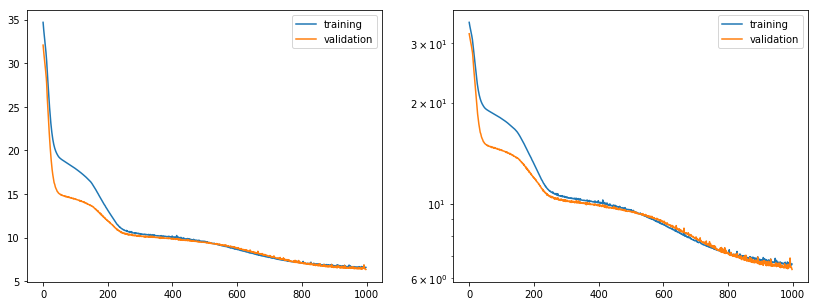

In [129]:
stack = np.array(stack)
fig, axes = plt.subplots(1, 2, figsize=(14,5))
plt.sca(axes[0])
plt.plot( stack[:,0], label='training' )
plt.plot( stack[:,1], label='validation')
plt.legend(loc=0)

plt.sca(axes[1])
plt.plot( stack[:,0], label='training' )
plt.plot( stack[:,1], label='validation')
plt.legend(loc=0)
plt.yscale('log')

The fit to the training data decreases rapidly, with some quasi-plateaus.  The validation fit also improves, and at times is significantly better than the training results.  They eventually appear to converge, which is a pleasant surprise.

(3,)

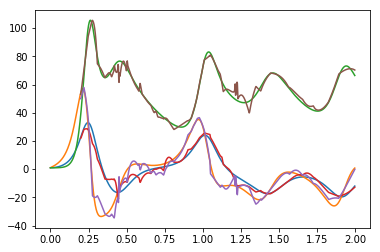

In [115]:
# Predicted and actual time series for the training data appear to agree very well.
#
plt.plot(tvals[0:900+ndt], xyz[0:900+ndt,:])
plt.plot( tvals[ndt:900+ndt], model.predict( xyz[0:900]) )
#xyz[1000].shape

The fit to the entire sequence appears to be surprisingly good.

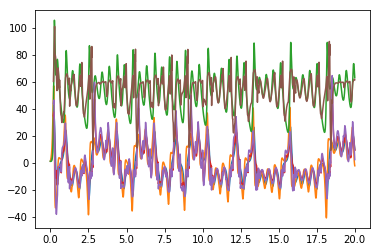

In [132]:
plt.plot(tvals[0:9900+ndt], xyz[0:9900+ndt,:])
plt.plot( tvals[ndt:9900+ndt], model.predict(xyz[0:9900]) )

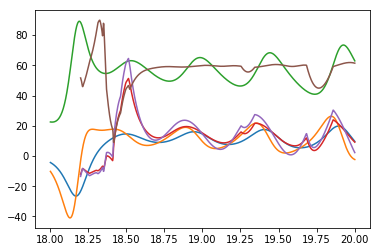

In [137]:
#zoom in on tail end of validation region
#
plt.plot( tvals[9000:9900+ndt], xyz[9000:9900+ndt,:])
plt.plot( tvals[9000+ndt:9900+ndt], model.predict(xyz[9000:9900,:]) ) 

## Assignment

#### The validation curve appears to fluctuate more than the training curve at later epochs.  Discuss why this might be.

#### Tidy up code (eg. factor out magic numbers like 9000:9900) and make sure it is correct.

#### How does prediction quality decrease for larger `ndt` ie. further into the future?

#### Explore changing hyper parameters (the number of layers, nodes per layer etc.) to improve prediction quality


### Optional

#### How does prediction quality decrease for smaller block sizes (eg.100 instead of 900)?

#### Explore the use of "lag vectors" as inputs

For example, take a 1000x3 vector and rearrange it to 500x6 by grouping pairs of state vectors together.  

    xyz[0:999,:].reshape(-1,6)

